In [2]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install bs4

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install kagglehub 0.3.13

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement 0.3.13 (from versions: none)
ERROR: No matching distribution found for 0.3.13


In [7]:
import os
import sys
import time
import json
import joblib
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import nltk
import re
import string
import emoji
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import RobertaTokenizerFast, TFRobertaModel
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TextClassificationPipeline,
    Trainer,
    TrainingArguments,
    pipeline
)


In [8]:
import pandas as pd

# Load the full dataset
df = pd.read_csv(r"C:\Users\jothi\Desktop\AG NEWS PROJECT\train.csv", header=None, names=["class", "title", "description"])

# Check class distribution
print(df["class"].value_counts())

# Sample 50% from each class to maintain balance
sampled_df = df.groupby("class", group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state=42))

# Confirm new distribution
print(sampled_df["class"].value_counts())

# Save the subset if needed
sampled_df.to_csv("train_50_percent.csv", index=False)

class
3              30000
2              30000
4              30000
1              30000
Class Index        1
Name: count, dtype: int64
class
1    15000
2    15000
3    15000
4    15000
Name: count, dtype: int64


C:\Users\jothi\AppData\Local\Temp\ipykernel_24784\1793310825.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby("class", group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state=42))


In [9]:
import pandas as pd

# Load the full dataset
df = pd.read_csv(r"C:\Users\jothi\Desktop\AG NEWS PROJECT\test.csv", header=None, names=["class", "title", "description"])

# Check class distribution
print(df["class"].value_counts())

# Sample 50% from each class to maintain balance
sampled_df = df.groupby("class", group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state=42))

# Confirm new distribution
print(sampled_df["class"].value_counts())

# Save the subset if needed
sampled_df.to_csv("test_50_percent.csv", index=False)

class
3              1900
2              1900
4              1900
1              1900
Class Index       1
Name: count, dtype: int64
class
1    950
2    950
3    950
4    950
Name: count, dtype: int64


C:\Users\jothi\AppData\Local\Temp\ipykernel_24784\2862552802.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby("class", group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state=42))


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

# Load the sampled dataset
df = pd.read_csv(r"C:\Users\jothi\Desktop\AG NEWS PROJECT\train_50_percent.csv")
df = pd.read_csv(r"C:\Users\jothi\Desktop\AG NEWS PROJECT\test_50_percent.csv")

# Combine title and description for richer input
df["text"] = df["title"].fillna("") + " " + df["description"].fillna("")

# Basic text cleaning
def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text)            # Normalize whitespace
    return text.strip().lower()

df["clean_text"] = df["text"].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["class"])

# Optional: Split into train/val for internal validation
X_train, X_val, y_train, y_val = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
)

EDA

In [11]:
#•	Visualize class distribution using bar charts.

import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# Class Distribution - Train
# --------------------------
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=train_df, palette="viridis")
plt.title("Class Distribution - Train Set")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.xticks([0,1,2,3], ["World", "Sports", "Business", "Sci/Tech"])
plt.show()

# --------------------------
# Class Distribution - Test
# --------------------------
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=test_df, palette="magma")
plt.title("Class Distribution - Test Set")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.xticks([0,1,2,3], ["World", "Sports", "Business", "Sci/Tech"])
plt.show()


NameError: name 'train_df' is not defined

<Figure size 600x400 with 0 Axes>

In [ ]:
#•	Generate word clouds for each category.

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# --------------------------
# Generate word clouds per category
# --------------------------
categories = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

plt.figure(figsize=(16,10))

for label, category in categories.items():
    text_data = " ".join(train_df[train_df["label"] == label]["text"].astype(str).tolist())
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="viridis",
        max_words=100
    ).generate(text_data)
    
    plt.subplot(2, 2, label+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {category}", fontsize=14)

plt.tight_layout()
plt.show()


In [10]:
# 	Average word count per article

import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# Word Count Calculation
# --------------------------
train_df["word_count"] = train_df["text"].apply(lambda x: len(str(x).split()))

# Average word count per class
avg_word_count = train_df.groupby("label")["word_count"].mean()

# Category names
categories = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(7,5))
sns.barplot(x=avg_word_count.index, y=avg_word_count.values, palette="viridis")

plt.title("Average Word Count per Article", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Average Word Count")
plt.xticks([0,1,2,3], [categories[i] for i in avg_word_count.index])
plt.show()


NameError: name 'train_df' is not defined

In [ ]:
#	Description/title length distribution

import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# Calculate word counts
# --------------------------
train_df["title_len"] = train_df["title"].apply(lambda x: len(str(x).split()))
train_df["desc_len"]  = train_df["description"].apply(lambda x: len(str(x).split()))

# --------------------------
# Plot distributions
# --------------------------
plt.figure(figsize=(12,5))

# Title length distribution
plt.subplot(1,2,1)
sns.histplot(train_df["title_len"], bins=30, kde=True, color="skyblue")
plt.title("Title Length Distribution", fontsize=14)
plt.xlabel("Number of Words in Title")
plt.ylabel("Frequency")

# Description length distribution
plt.subplot(1,2,2)
sns.histplot(train_df["desc_len"], bins=30, kde=True, color="salmon")
plt.title("Description Length Distribution", fontsize=14)
plt.xlabel("Number of Words in Description")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
# •	Create a heatmap showing frequent words per class.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re

# --------------------------
# Simple tokenizer (remove non-alphabetic, lowercase, split)
# --------------------------
def tokenize(text):
    text = re.sub(r"[^a-zA-Z]", " ", str(text))  # keep only letters
    return text.lower().split()

# --------------------------
# Get top words per class
# --------------------------
categories = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
top_n = 15   # top N words to display

word_freqs = {}

for label, cat_name in categories.items():
    texts = train_df[train_df["label"] == label]["text"].astype(str).tolist()
    tokens = []
    for t in texts:
        tokens.extend(tokenize(t))
    counter = Counter(tokens)
    most_common = dict(counter.most_common(top_n))
    word_freqs[cat_name] = most_common

# --------------------------
# Convert to DataFrame
# --------------------------
df_heatmap = pd.DataFrame(word_freqs).fillna(0).astype(int).T  # classes as rows

# --------------------------
# Plot Heatmap
# --------------------------
plt.figure(figsize=(14,6))
sns.heatmap(df_heatmap, cmap="YlGnBu", annot=True, fmt="d")
plt.title(f"Top {top_n} Frequent Words per Class", fontsize=16)
plt.ylabel("Category")
plt.xlabel("Word")
plt.show()


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform training data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

In [13]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize text
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=256)

In [12]:
pip install transformers datasets scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [13]:
from datasets import Dataset, ClassLabel

# Convert pandas to HF Dataset
dataset = Dataset.from_pandas(df_train[["text", "label"]])

# Manually cast 'label' column to ClassLabel
features = dataset.features.copy()
features["label"] = ClassLabel(names=["world", "sports", "business", "sci/tech"])  # Adjust if needed
dataset = dataset.cast(features)

# Now stratified split will work
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)

Casting the dataset: 100%|██████████| 3800/3800 [00:00<00:00, 70142.88 examples/s]


In [22]:
from datasets import Dataset, Features, ClassLabel, Value

# Step 1: Create the dataset
dataset = Dataset.from_pandas(df_train[["text", "label"]])

# Step 2: Define features with ClassLabel
features = Features({
    "text": Value("string"),
    "label": ClassLabel(num_classes=4)  # Adjust if you have more/less classes
})

# Step 3: Cast dataset to use ClassLabel
dataset = dataset.cast(features)

# Step 4: Now perform stratified split
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)

Casting the dataset: 100%|██████████| 3800/3800 [00:00<00:00, 498026.91 examples/s]


In [13]:
pip install --upgrade transformers


Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install --upgrade --user transformers


  Using cached transformers-4.56.2-py3-none-any.whl.metadata (40 kB)
Using cached transformers-4.56.2-py3-none-any.whl (11.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install torch --upgrade

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install --upgrade transformers

In [20]:
model = Model(inputs=input_ids, outputs=x)

In [21]:
x = Lambda(lambda inputs: inputs[0] + inputs[1])([input_ids, attention_mask])
model = Model(inputs=[input_ids, attention_mask], outputs=x)

In [23]:

#  Encode labels
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_id'])

#  Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Load tokenizer from fine-tuned model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

#  Tokenize
train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_encodings = tokenizer(
    X_test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

from transformers import TFAutoModel

base_model = TFAutoModel.from_pretrained(
    model_name,
    from_pt=True
)


from tensorflow.keras.layers import Lambda

# Inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Lambda wrapper with explicit output shape
def bert_layer(inputs):
    input_ids, attention_mask = inputs
    bert_output = base_model(input_ids, attention_mask=attention_mask)[0]
    return bert_output[:, 0, :]  # [CLS] token

cls_token = Lambda(
    bert_layer,
    output_shape=(base_model.config.hidden_size,)
)([input_ids, attention_mask])

# Classification head
output = Dense(y_train.shape[1], activation='softmax')(cls_token)

# Final model
model_bert = Model(inputs=[input_ids, attention_mask], outputs=output)
model_bert.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])





# Train
history = model_bert.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask']], y_test),
    epochs=10,
    batch_size=32
)


#  Evaluate
y_pred_probs = model_bert.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Accuracy:", accuracy_score(y_true, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - accuracy: 0.6658 - loss: 0.9447 - val_accuracy: 0.7789 - val_loss: 0.6844
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 496s 5s/step - accuracy: 0.8020 - loss: 0.6253 - val_accuracy: 0.8224 - val_loss: 0.5755
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 437s 5s/step - accuracy: 0.8293 - loss: 0.5418 - val_accuracy: 0.8184 - val_loss: 0.5441
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 448s 5s/step - accuracy: 0.8342 - loss: 0.5031 - val_accuracy: 0.8250 - val_loss: 0.5117
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 0.8408 - loss: 0.4746 - val_accuracy: 0.8329 - val_loss: 0.4965
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 447s 5s/step - accuracy: 0.8484 - loss: 0.4574 - val_accuracy: 0.8289 - val_loss: 0.4925
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 497s 5s/step - accuracy: 0.8533 - loss: 0.4421 - val_accuracy: 0.8421 - val_loss: 0.4838
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 584s 6s/step - accuracy: 0.8543 - loss: 0.4271 - val_accuracy: 0.8329 - v

NameError: name 'precision_recall_fscore_support' is not defined

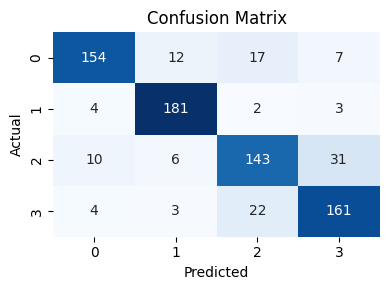

In [24]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(4, 3))  # Small size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [25]:
import joblib

joblib.dump(model_bert, "transformer_bert(epoch=10)_model.pkl")

['transformer_bert(epoch=10)_model.pkl']

In [26]:
model_bert.save("transformer_bert(epoch=10)_model.h5")

In [14]:
# !pip install transformers datasets scikit-learn

import pandas as pd
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# --------------------------
# 1. Load Dataset (AG News)
import pandas as pd

import pandas as pd

# Load your 50% subset
train_df = pd.read_csv(r"C:\Users\jothi\Desktop\AG NEWS PROJECT\train_50_percent.csv", header=0)
test_df  = pd.read_csv(r"C:\Users\jothi\Desktop\AG NEWS PROJECT\test_50_percent.csv", header=0)

# Columns: [label, title, description]
train_df.columns = ["label", "title", "description"]
test_df.columns  = ["label", "title", "description"]

# Convert labels to integers
train_df["label"] = train_df["label"].astype(int) - 1
test_df["label"]  = test_df["label"].astype(int) - 1

# Combine title + description into one text column
train_df["text"] = train_df["title"].astype(str) + " " + train_df["description"].astype(str)
test_df["text"]  = test_df["title"].astype(str) + " " + test_df["description"].astype(str)

print(train_df.head())
print(test_df.head())

train_dataset = Dataset.from_pandas(train_df[["text", "label"]])
test_dataset = Dataset.from_pandas(test_df[["text", "label"]])

# --------------------------
# 2. Tokenization
# --------------------------
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Remove text column & format for torch
train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])
train_dataset.set_format("torch")
test_dataset.set_format("torch")

# --------------------------
# 3. Load Pretrained Model
# --------------------------
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4
)

# --------------------------
# 4. Define Metrics (scikit-learn)
# --------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

# --------------------------
# 5. Training Arguments
# --------------------------
import inspect
from transformers import TrainingArguments

# Basic common kwargs (edit these hyperparams as needed)
common_kwargs = {
    "output_dir": "./results",
    "learning_rate": 2e-5,
    "per_device_train_batch_size": 16,
    "per_device_eval_batch_size": 16,
    "num_train_epochs": 3,
    "weight_decay": 0.01,
    "logging_dir": "./logs",
    "logging_steps": 100,
}

# Inspect the TrainingArguments __init__ signature to see supported parameter names
sig = inspect.signature(TrainingArguments.__init__)
param_names = set(sig.parameters.keys())
param_names.discard("self")  # not a real kwarg

# Add evaluation/save related kwargs using the names available in this version
if "eval_strategy" in param_names:
    common_kwargs["eval_strategy"] = "epoch"      # new name in recent versions
elif "evaluation_strategy" in param_names:
    common_kwargs["evaluation_strategy"] = "epoch"  # older name

if "save_strategy" in param_names:
    common_kwargs["save_strategy"] = "epoch"
elif "save_steps" in param_names:
    common_kwargs["save_steps"] = 500

# load_best_model_at_end exists in many versions; add only if supported
if "load_best_model_at_end" in param_names:
    common_kwargs["load_best_model_at_end"] = True

# Finally construct TrainingArguments
try:
    training_args = TrainingArguments(**common_kwargs)
    print("TrainingArguments created with supported params:", list(common_kwargs.keys()))
except TypeError as e:
    # Fallback: create a minimal TrainingArguments without eval/save-related options
    print("Fallback: some kwargs not supported. Error:", e)
    minimal_kwargs = {
        "output_dir": "./results",
        "per_device_train_batch_size": 16,
        "per_device_eval_batch_size": 16,
        "num_train_epochs": 3,
    }
    training_args = TrainingArguments(**minimal_kwargs)
    print("Fallback TrainingArguments created (minimal).")



# --------------------------
# 6. Trainer API
# --------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# --------------------------
# 7. Train the Model
# --------------------------
trainer.train()

# --------------------------
# 8. Evaluate
# --------------------------
results = trainer.evaluate()
print(results)

# --------------------------
# 9. Save Model
# --------------------------
trainer.save_model("./distilbert_agnews_model.h5")
tokenizer.save_pretrained("./distilbert_agnews_model.h5")


   label                                              title  \
0      0  Large Explosion Heard in Central Baghdad (Reut...   
1      0         Israel OKs More West Bank Settlement Homes   
2      0          Scores of Iraqis die in 3 days of attacks   
3      0                 At least 20 dead in Kurkik bombing   
4      0                     Israel, Egypt in Prisoner Swap   

                                         description  \
0  Reuters - A large blast was heard in central\B...   
1  JERUSALEM Aug. 23, 2004 - Israel announced pla...   
2  US troops fought a gunbattle with insurgents a...   
3  A suicide attacker detonated a car bomb near a...   
4   CAIRO (Reuters) - Israel released six Egyptia...   

                                                text  
0  Large Explosion Heard in Central Baghdad (Reut...  
1  Israel OKs More West Bank Settlement Homes JER...  
2  Scores of Iraqis die in 3 days of attacks US t...  
3  At least 20 dead in Kurkik bombing A suicide a...  
4  Israel

Map: 100%|██████████| 3800/3800 [00:00<00:00, 6789.81 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\jothi\AppData\Local\Temp\ipykernel_12328\1562231422.py:131: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


TrainingArguments created with supported params: ['output_dir', 'learning_rate', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'num_train_epochs', 'weight_decay', 'logging_dir', 'logging_steps', 'eval_strategy', 'save_strategy', 'load_best_model_at_end']


2025/09/13 20:53:15 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

c:\Users\jothi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.366800,0.256807,0.920263,0.920608
2,0.234800,0.178232,0.949474,0.949290
3,0.229100,0.152208,0.960263,0.960192


c:\Users\jothi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\jothi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\jothi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.15220767259597778, 'eval_accuracy': 0.9602631578947368, 'eval_f1': 0.9601919772092182, 'eval_runtime': 500.337, 'eval_samples_per_second': 7.595, 'eval_steps_per_second': 0.476, 'epoch': 3.0}


('./distilbert_agnews_model.h5\\tokenizer_config.json',
 './distilbert_agnews_model.h5\\special_tokens_map.json',
 './distilbert_agnews_model.h5\\vocab.txt',
 './distilbert_agnews_model.h5\\added_tokens.json',
 './distilbert_agnews_model.h5\\tokenizer.json')

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --------------------------
# 10. Predictions on Test Set
# --------------------------
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# --------------------------
# 11. Classification Report
# --------------------------
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["World", "Sports", "Business", "Sci/Tech"]))

# --------------------------
# 12. Confusion Matrix
# --------------------------
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


c:\Users\jothi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 Classification Report:
              precision    recall  f1-score   support

       World       0.98      0.93      0.96       950
      Sports       0.98      0.99      0.99       950
    Business       0.95      0.93      0.94       950
    Sci/Tech       0.94      0.98      0.96       950

    accuracy                           0.96      3800
   macro avg       0.96      0.96      0.96      3800
weighted avg       0.96      0.96      0.96      3800


📊 Confusion Matrix:
[[887  14  33  16]
 [  4 942   4   0]
 [ 13   1 888  48]
 [  3   1  14 932]]


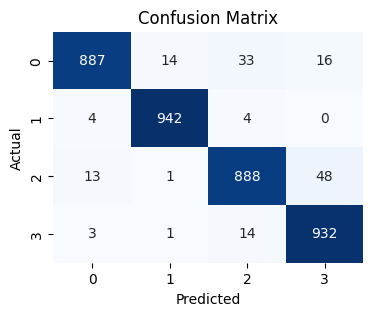

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(4, 3))  # Small size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [27]:
joblib.dump(model_bert, "distilbert_model.pkl")

['distilbert_model.pkl']

In [28]:
model_bert.save("distilbert_model.h5")

In [19]:
pip install tabulate


Note: you may need to restart the kernel to use updated packages.Collecting tabulate



  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [20]:
from tabulate import tabulate

# Define the data
headers = ["Model Name", "Model Type", "Accuracy", "F1-Score", "Pros", "Cons"]
rows = [
    [
        "Logistic Regression", "ML", 0.92, 0.92,
        "1. Fast training and inference\n2. Easy to interpret and implement\n3. Good for linearly separable text",
        "1. Limited to linear decision boundaries\n2. Poor performance on long or complex text\n3. Requires manual feature engineering"
    ],
    [
        "GRU", "DL", 0.91, 0.91,
        "1. Captures sequential dependencies\n2. Handles variable-length input\n3. Suitable for moderately complex NLP tasks",
        "1. Slower training than ML models\n2. Sensitive to vanishing gradients\n3. Needs careful hyperparameter tuning"
    ],
    [
        "DistilBERT", "Pre-trained", 0.96, 0.96,
        "1. Excellent contextual understanding\n2. Pre-trained on large corpora\n3. High accuracy with fine-tuning",
        "1. High memory and compute requirements\n2. Slower inference speed\n3. May overfit on small datasets"
    ]
]

# Print the table
print("News Article Classifier Comparison:\n")
print(tabulate(rows, headers=headers, tablefmt="grid"))

News Article Classifier Comparison:

+---------------------+--------------+------------+------------+----------------------------------------------+---------------------------------------------+
| Model Name          | Model Type   |   Accuracy |   F1-Score | Pros                                         | Cons                                        |
+=====================+==============+============+============+==============================================+=============================================+
| Logistic Regression | ML           |       0.92 |       0.92 | 1. Fast training and inference               | 1. Limited to linear decision boundaries    |
|                     |              |            |            | 2. Easy to interpret and implement           | 2. Poor performance on long or complex text |
|                     |              |            |            | 3. Good for linearly separable text          | 3. Requires manual feature engineering      |
+--------------